## Square Attack

The Square Attack is a black-box method used to generate adversarial samples. Unlike 'white-box' approachs such as PGD or FGSM, the Square Attack does not require knowing model weights or gradients. 

While other black-box attack take many queries to perform attacks the square attack makes relatively few.  The attack works by taking repeated alterations in the shape of a square on the image, keeping it if it increases the loss of the model. The Square Attack, upon release, was successful enough that it even outperformed some existing white-box approaches on benchmarks.

## 1. Loading and Processing Models and Images

In [ ]:
# IF YOU ARE IN COLAB OR HAVE NOT INSTALLED `xlab-security`
!pip install xlab-security # should not take more than a minute or two to run

In [1]:
import xlab
from xlab.utils import prediction, process_image, show_image, CIFAR10
import torch
import numpy as np
import random
from huggingface_hub import hf_hub_download
from xlab.models import MiniWideResNet, BasicBlock
import torch

classes = CIFAR10().classes
IMG_PATH = 'car.jpg'

model = MiniWideResNet()
model_path = hf_hub_download(
    repo_id="uchicago-xlab-ai-security/tiny-wideresnet-cifar10",
    filename="adversarial_basics_cnn.pth"
)

model = torch.load(model_path, map_location='cpu', weights_only = False)

### Task 1

In the $ L_\infty $ square attack, the attacker adds random square-shaped changes to the image to increase the classifiers loss. The first step to adding these squares is to choose their location. In the function below you will return a random $y$ and $x$ to determine the upper left hand side of a square we will add in another function (shown with the star below).

<p style="text-align: center">
<img width="300px" src="https://xlabaisecurity.com/square/square_loc.png">
</p>

The function takes in two arguments:

1. `w`: the sidelength of the original image. For CIFAR-10 $w = 32$ because images are $3 \times 32 \times 32$.
2. `h`: the size of the square we will be adding to the image.

<details>
<summary>🔐 <b>Solution for Task #1</b></summary>

```python
def get_rand_square_coordinates(w, h):
    """Generates random coordinates for the upper left corner of a square patch
    
    Args:
        w (int): Side length of the original image
        h (int): Side length of the square patch to be placed
        
    Returns:
        tuple: (y, x) coordinates for the upper left corner of the square
    """
    randy = torch.randint(0, w - h, (1,)).item()
    randx = torch.randint(0, w - h, (1,)).item() 

    return randy, randx
```
</details>

In [2]:
def get_rand_square_coordinates(w, h):
    """Generates random coordinates for the upper left corner of a square patch
    
    Args:
        w (int): Side length of the original image
        h (int): Side length of the square patch to be placed
        
    Returns:
        tuple: (y, x) coordinates for the upper left corner of the square
    """

    randy = torch.randint(0, w - h, (1,)).item()
    randx = torch.randint(0, w - h, (1,)).item() 

    return randy, randx
    
    raise NotImplementedError("get_rand_square_coordinates hasn't been implemented.")

In [3]:
_ = xlab.tests.square.task1(get_rand_square_coordinates)


Running tests for Task 1: get_rand_square_coordinates...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../../../xlab-python-package/xlab/tests/square.py::TestTask1::test_output_type_and_bounds PASSED [ 50%]
../../../xlab-python-package/xlab/tests/square.py::TestTask1::test_randomness_across_calls PASSED [100%]

=============================== warnings summary ===============================
../../../../../../anaconda3/envs/xlab/lib/python3.11/site-packages/_pytest/config/__init__.py:1290
  /Users/zephaniahroe/anaconda3/envs/xlab/lib/python3.11/site-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
========================= 2 passed, 1 warning in 0.01s ====================

### Task 2

Now we can design a function which creates the random square which we will add to our image. This function will return delta tensor where each value represents how much the square will effect each number in the original image. The tensor will be all zeros except for a small square which we will choose the value of randomly.

The function will take in four arguments:

1. `c`: the number of color channels in the image. For CIFAR-10 there are three channels: red, green, and blue.
2. `w`: the sidelength of the original image. For CIFAR-10 $w = 32$ because images are $3 \times 32 \times 32$.
3. `h`: the size of the square we will be adding to the image.
4. `epsilon`: this determines the range of values that the square will be sampled from.

Each color channel in the square will be independently chosen. Each value is sampled from between $ -2\epsilon $ and $ 2\epsilon$. For CIFAR-10 there are three color channels, so you would sample only 3 random values for the square. 

To make this concrete, take a look at the image below. This is a plot of a tensor which `l_inf_dist` may return. Note that most values in each color channel are zero. The values that are not zero are the same accross color channels. Within the same color channel, the values are all the same, but each color channel has a different value.

<p style="text-align: center">
<img width="800px" src="https://xlabaisecurity.com/square/example_square.png">
</p>


<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python
def l_inf_dist(epsilon, h, w, c):
    """Generates a sparse adversarial perturbation by adding uniform noise to a random square patch
    
    Args:
        epsilon (float): Maximum perturbation magnitude.
        h (int): Height and width of the square patch to perturb.
        w (int): Height and width of the full image.
        c (int): Number of color channels.
        
    Returns:
        [c, w, w]: Sparse perturbation tensor with random noise in a single square patch.
    """
    randy, randx = get_rand_square_coordinates(w, h)

    ps = (torch.rand(c,1,1) - 0.5) * 4 * epsilon
    delta = torch.zeros(c, w, w)
    delta[:,randy:randy+h, randx:randx+h] = ps

    return delta
```

</details>

In [4]:
def l_inf_dist(epsilon, h, w, c):
    """Generates a sparse adversarial perturbation by adding uniform noise to a random square patch
    
    Args:
        epsilon (float): Maximum perturbation magnitude.
        h (int): Height and width of the square patch to perturb.
        w (int): Height and width of the full image.
        c (int): Number of color channels.
        
    Returns:
        [c, w, w]: Sparse perturbation tensor with random noise in a single square patch.
    """
    randy, randx = get_rand_square_coordinates(w, h)

    ps = (torch.rand(c,1,1) - 0.5) * 4 * epsilon
    delta = torch.zeros(c, w, w)
    delta[:,randy:randy+h, randx:randx+h] = ps

    return delta
    # raise NotImplementedError("l_inf_square_attack hasn't been implemented.")

Now run the two cells below. If you implemented your function correctly, the top cell and the bottom cell should return squares of two different sizes starting in two different positions.

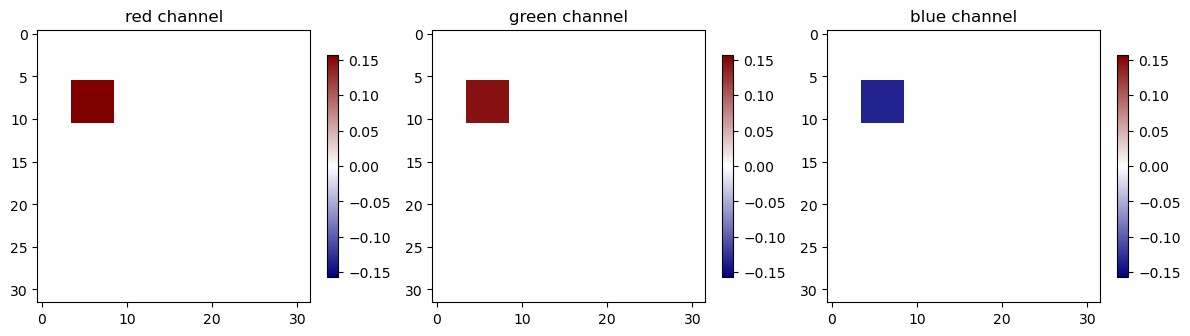

In [5]:
delta = l_inf_dist(0.1, 5, 32, 3)
_ = xlab.utils.plot_tensors([
        delta[0],
        delta[1],
        delta[2]
    ],
    ncols=3,
    titles=["red channel", "green channel", "blue channel"] 
)

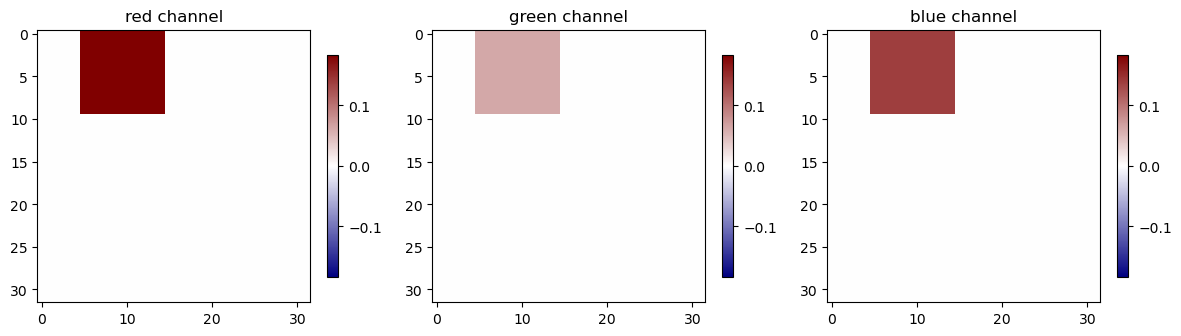

In [6]:
delta = l_inf_dist(0.1, 10, 32, 3)
_ = xlab.utils.plot_tensors([
        delta[0],
        delta[1],
        delta[2]
    ],
    ncols=3,
    titles=["red channel", "green channel", "blue channel"] 
)

In [7]:
_ = xlab.tests.square.task2(l_inf_dist)


Running tests for Task 2: l_inf_dist...
🎉 All tests passed! (2/2)

Detailed output:
============================= test session starts ==============================
collecting ... collected 2 items

../../../xlab-python-package/xlab/tests/square.py::TestTask2::test_output_shape_and_type PASSED [ 50%]
../../../xlab-python-package/xlab/tests/square.py::TestTask2::test_randomness_across_runs PASSED [100%]

=============================== warnings summary ===============================
../../../../../../anaconda3/envs/xlab/lib/python3.11/site-packages/_pytest/config/__init__.py:1290
  /Users/zephaniahroe/anaconda3/envs/xlab/lib/python3.11/site-packages/_pytest/config/__init__.py:1290: PytestAssertRewriteWarning: Module already imported so cannot be rewritten; anyio
    self._mark_plugins_for_rewrite(hook, disable_autoload)

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
========================= 2 passed, 1 warning in 0.01s =========================



## Task 3

Before we implement our attack we have to determine a schedule for the sizes of the squares we will be adding to our image. We would like to start with large squares to make high level changes to the image before moving to smaller squares to make more fine-grained adjustments.

The scedule proposed in the paper takes a square that has a size such that it modifies roughly $p$ percentage of pixels in the image. Then after some amount of iterations, the value of $p$ is halved so that the next round of squares will be smaller. More concretely, if $w$ is the side length of the original image the side length of the square to modify is the closest positive integer to $\sqrt{p * w^2}$. 

Below you will see a constant array `HALF_POINT_VALUES`. At these values $p$ is halved. We hardcode the same values for `HALF_POINT_VALUES` used in the original paper. In your function, you will use this variable to determine the side length of the modifying square at iteration $i$ given $w$ and an inital $p$.

**Sidenote:** Our solution uses a loop to find `square_schedule` which is not the most efficient solution but we believe it is the easiest to understand. In the [code released for the paper](https://github.com/max-andr/square-attack/blob/master/attack.py), the authors use a large if/elif/else statement which is called at each iteration but this is also suboptimal. The most efficient solution would not require so many repeated calls to the scheduler function but this would make the code harder to understand so we leave this as an exercise to the reader.

In [8]:
HALF_POINT_VALUES = [10, 50, 200, 1000, 2000, 4000, 6000, 8000]

def square_schedule(i, w, inital_p=0.10):
    p = inital_p
    
    for half_point in HALF_POINT_VALUES:
        if half_point <= i:
            p /= 2

    side_length = int((p * w**2) ** (1/2))

    # make sure the side length is not less than 2
    if side_length < 2:
        return 2
    else:
        return side_length

In [11]:
_ = xlab.tests.square.task3(square_schedule)


Running tests for Task 3: square_schedule...
📊 Results: 2 passed, 2 failed out of 4 total

Detailed output:
============================= test session starts ==============================
collecting ... collected 3 items

../../../xlab-python-package/xlab/tests/square.py::TestTask3::test_basic_no_halving PASSED [ 33%]
../../../xlab-python-package/xlab/tests/square.py::TestTask3::test_single_halving FAILED [ 66%]
../../../xlab-python-package/xlab/tests/square.py::TestTask3::test_minimum_enforced PASSED [100%]

=================================== FAILURES ===================================
________________________ TestTask3.test_single_halving _________________________
../../../xlab-python-package/xlab/tests/square.py:151: in test_single_halving
    assert side == expected
           ^^^^^^^^^^^^^^^^
E   AssertionError
=============================== warnings summary ===============================
../../../../../../anaconda3/envs/xlab/lib/python3.11/site-packages/_pytest/config/__ini

## 2.1 The Square Attack loop.
### Task 2
Now, we will use the distribution within the main loop of the  $ L_\infty $ attack. Similar code will be used to run the $ L_2 $ attack. Intuitively, this algorithm involves choosing a window size $ h $ using a schedule of sorts, and then altering the image using the above helper function, until the image is adversarial or a particular number of iterations is reached.

$$
\begin{array}{l}
\text{\bf Algorithm: Projected Gradient-Free Adversarial Attack} \\
\hline
\text{\bf Input: } \text{classifier } f, \text{ point } x \in \mathbb{R}^d, \text{ image size } w, \text{ number of color channels } c, \\
\quad l_p\text{-radius } \epsilon, \text{ label } y \in \{1, \dots, K\}, \text{ number of iterations } N \\
\text{\bf Output: } \text{approximate minimizer } \hat{x} \in \mathbb{R}^d \text{ of the problem stated in Eq. (1)} \\[0.5em]
\hat{x} \leftarrow \text{init}(x) \\ 
l^* \leftarrow L(f(x), y) \\
i \leftarrow 1 \\
\text{\bf while } i < N \text{ and } \hat{x} \text{ is not adversarial \bf do} \\
\quad h^{(i)} \leftarrow \text{side length of the square to modify (according to some schedule)} \\
\quad \delta \sim P(\epsilon, h^{(i)}, w, c, \hat{x}, x) \\
\quad \hat{x}_{\text{new}} \leftarrow \text{Project } \hat{x} + \delta \text{ onto } \{z \in \mathbb{R}^d : \|z - x\|_p \le \epsilon\} \cap [0, 1]^d \\
\quad l_{\text{new}} \leftarrow L(f(\hat{x}_{\text{new}}), y) \\
\quad \text{\bf if } l_{\text{new}} < l^* \text{ \bf then } \hat{x} \leftarrow \hat{x}_{\text{new}}, l^* \leftarrow l_{\text{new}} \\
\quad i \leftarrow i + 1 \\
\text{\bf end } \\
\hline
\end{array}
$$

<details>
<summary>💡 <b>Hint for Task #2</b></summary>

In our solution, we use the div operator, ```//``` for the floor function.
</details>


<details>
<summary>🔐 <b>Solution for Task #2</b></summary>

```python
def l_inf_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=15/1000, max_h = 6):
    """Generates adversarial example using iterative square patch perturbations with L-infinity constraints
    
    Args:
        model: Neural network model with forward() method.
        loss_fn: Loss function for optimization.
        x [c, w, w]: Input image tensor.
        y (int): True class label.
        N (int): Maximum number of optimization iterations.
        w (int): Image width and height.
        c (int): Number of color channels.
        epsilon (float): Maximum perturbation magnitude per pixel.
        max_h (int): Initial square patch size, gradually reduced during optimization.
    
    Returns:
        [c, w, w]: Adversarial image tensor with successful misclassification or best attempt.
    """
    x_hat = x
    loss = loss_fn(model(x), y)
    i = 1
    h = max_h
    while i < N and prediction(model, x_hat)[0] == y:
        if i % (N // max_h) == 0:
            if h > 2:
                h -= 1
        delta = l_inf_dist(h=h, epsilon=epsilon, w=w, c=c)
        x_new = x_hat + delta
        x_new = torch.clamp(x_new, 0, 1)
        loss_new = loss_fn(model(x_new), y)
        if loss_new > loss:
            loss = loss_new
            x_hat = x_new 
        i += 1
    return x_hat
```

</details>

A basic schedule could involve reducing h by one (from max_h) every N//h iterations until the value of 2 is reached. This reduces the size of the window over time, reducing the scale of the perturbations, simulating a sort of convergence onto an adversarial image.

In [9]:
def l_inf_square_attack(model, loss_fn, x, y, N, w=32, c=3, epsilon=8/255):
    """Generates adversarial examples by iteratively adding square patches to maximize classification loss
    
    Args:
        model: Neural network model with forward() method.
        loss_fn: Loss function for optimization.
        x [c, w, w]: Input image tensor.
        y (int): True class label.
        N (int): Maximum number of optimization iterations.
        w (int): Image width and height.
        c (int): Number of color channels.
        epsilon (float): Maximum perturbation magnitude per pixel.
    
    Returns:
        [c, w, w]: Adversarial image tensor that misclassifies or maximizes loss within iteration limit.
    """

    x_hat = x.clone()
    max_loss = loss_fn(model(x), y)
    i = 1
    
    while i < N and prediction(model, x_hat)[0] == y:
        h = square_schedule(i, w)

        # 1. call l_inf_dist to get next delta
        delta = l_inf_dist(epsilon, h, w, c)
        
        # 2. add delta to x_hat to find x_new
        x_new = x_hat + delta

        # 3. clamp x_new between 0 and 1 and within the L-infinity budget
        x_new = xlab.utils.clip(x_new, x, epsilon)

        # 4. calculate loss
        loss_new = loss_fn(model(x_new), y)

        # 5. if new loss is greater than max_loss, keep the square on
        # the image set max_loss to new value
        if loss_new > max_loss:
            max_loss = loss_new
            x_hat = x_new 
        i += 1
    
    return x_hat

        # delta = # 1. call l_inf_dist to get next delta
        # x_new = # 2. add delta to x_hat to find x_new
        
        # # 3. clamp x_new between 0 and 1 and within the L-infinity budget
        # # HINT: call xlab.utils.clip() calls the cliping function from
        # # the FGSM section: https://xlabaisecurity.com/adversarial/adversarialimages/
        # x_new = ### YOUR CODE HERE ###

    # raise NotImplementedError("l_inf_square_attack hasn't been implemented.")

To test your attack, you can run the below cell. You should see that your image fools the classifer when it originally got the answer correct. Also, you should see that the max difference of any pixel value in the image is about 0.0314 which is roughly equal to our epsilon value $8/255$.

If your output looks similar to ours below, you can be confident that your implementation is correct:

```
CLEAN IMAGE
--------------------------------------------------------------------------------
cat with probability 0.9201

ADVERSARIAL IMAGE
--------------------------------------------------------------------------------
dog with probability 0.5006
Max delta of any pixel value = 0.0314
```

CLEAN IMAGE
--------------------------------------------------------------------------------
cat with probability 0.9201

ADVERSARIAL IMAGE
--------------------------------------------------------------------------------
dog with probability 0.5405
Max delta of any pixel value = 0.0314

show_image(x_adv)
--------------------------------------------------------------------------------


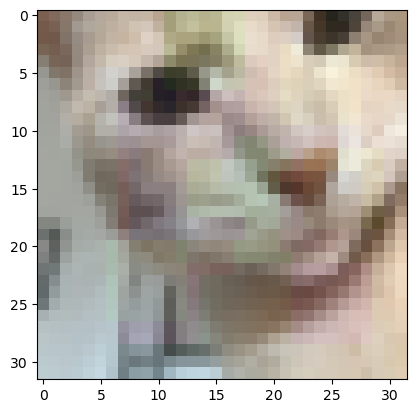

In [10]:
img = xlab.utils.process_image('cat.jpg')
label = prediction(model, img)[0]

print("CLEAN IMAGE\n" + "-" * 80)
pred = prediction(model, img)
print(f"{classes[pred[0]]} with probability {pred[1][0]:.4f}")

print("\nADVERSARIAL IMAGE\n" + "-" * 80)
loss_fn = torch.nn.CrossEntropyLoss()
x_adv = l_inf_square_attack(model, loss_fn, img, label, 500)
pred = prediction(model, x_adv)
print(f"{classes[pred[0]]} with probability {pred[1][0]:.4f}")
print(f"Max delta of any pixel value = {torch.max(img- x_adv):.4f}")

print("\nshow_image(x_adv)\n" + "-" * 80)
show_image(x_adv)